# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [1]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [2]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [28]:
# Your code here
X = df.drop(columns='Cover_Type')
y = df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, stratify=y)
# X_train = pd.DataFrame(X_train, columns = X_train.columns, index=X_train.index)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [29]:
# Your code here
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [30]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [60]:
# Replace None with appropriate code

# Relevant imports
from sklearn.metrics import classification_report
# Creating the model
knn_baseline_model = KNeighborsClassifier().fit(X_train_scaled, y_train)

# Perform cross-validation
cv = cross_validate(knn_baseline_model,X_train_scaled,y_train,scoring='neg_log_loss')
knn_baseline_log_loss = -np.mean(cv['test_score'])
print(classification_report(y_test,knn_baseline_model.predict(X_test_scaled)))
knn_baseline_log_loss

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8939
           1       0.91      0.87      0.89       687

    accuracy                           0.98      9626
   macro avg       0.95      0.93      0.94      9626
weighted avg       0.98      0.98      0.98      9626



0.12964546386734574

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [38]:
# Replace None with appropriate text
"""
looks like it performs slightly better, but takes longer to predict (about.4 seconds per fold)
"""

'\nlooks like it performs slightly better, but takes longer to predict (about.4 seconds per fold)\n'

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

### model 1

In [40]:
# 3 neighbors
model1 = KNeighborsClassifier(n_neighbors=3)
# 3 neighbors, manhattan distance metric
model1_man = KNeighborsClassifier(n_neighbors=3, p=1) 

cv1 = cross_validate(model1, X_train_scaled, y_train, scoring='neg_log_loss')
cv1_log_loss = -np.mean(cv1['test_score'])
print(cv1_log_loss)
cv1_man = cross_validate(model1, X_train_scaled, y_train, scoring='neg_log_loss')
cv1_man_log_loss = -np.mean(cv1['test_score'])
print(cv1_man_log_loss)

0.1811320692968615
0.1811320692968615


Seems like distance calculator doesn't affect the score  
less neighbors is likely overfitting, so the score is worse

### model 2

In [42]:
# 10,20,50 neighbors
n_neighbors = [10,20,50]
models = [KNeighborsClassifier(n_neighbors=n) for n in n_neighbors]
cvs = [cross_validate(model, X_train_scaled, y_train, scoring='neg_log_loss') for model in models]
print([f"{n} neighbors: {-np.mean(cv['test_score'])}" for n, cv in zip(n_neighbors, cvs)])

['10 neighnors: 0.07502202520388171', '20 neighnors: 0.06461918519769719', '50 neighnors: 0.07871799429857203']


n_neighbors of 20 is the best between these

### model 3

In [83]:
# 1,2, ... , 30 neighbors
n_neighbors = [i for i in range(1,31)]
models = [KNeighborsClassifier(n_neighbors=n).fit(X_train_scaled,y_train) for n in n_neighbors]
cvs = [cross_validate(model, X_train_scaled, y_train, scoring='neg_log_loss') for model in models]
print(np.array([f"{n} score_time: {np.mean(cv['score_time'])}" for n, cv in zip(n_neighbors, cvs)]))
print(np.array([f"{n} neighbors: {-np.mean(cv['test_score'])}" for n, cv in zip(n_neighbors, cvs)]))

['1 score_time: 0.9514956474304199' '2 score_time: 0.8627528667449951'
 '3 score_time: 0.8367946147918701' '4 score_time: 0.8354050159454346'
 '5 score_time: 0.8480497837066651' '6 score_time: 0.8173780918121338'
 '7 score_time: 0.8683815956115722' '8 score_time: 0.9367967128753663'
 '9 score_time: 0.9130553722381591' '10 score_time: 1.056706190109253'
 '11 score_time: 0.8616247177124023' '12 score_time: 1.1336066246032714'
 '13 score_time: 1.0320155620574951' '14 score_time: 0.9781744480133057'
 '15 score_time: 0.9028046131134033' '16 score_time: 0.7971481323242188'
 '17 score_time: 0.7956681728363038' '18 score_time: 0.8059692859649659'
 '19 score_time: 0.7923749923706055' '20 score_time: 0.8010362148284912'
 '21 score_time: 0.8002038478851319' '22 score_time: 0.8362800598144531'
 '23 score_time: 0.8276209831237793' '24 score_time: 1.0531653881072998'
 '25 score_time: 0.7670713901519776' '26 score_time: 0.7713396072387695'
 '27 score_time: 0.766688060760498' '28 score_time: 0.7934457

In [ ]:
from sklearn.metrics import roc_curve, auc
models = [KNeighborsClassifier(n_neighbors=n).fit(X_train_scaled,y_train) for n in n_neighbors]
labels = ['knn_baseline_model', 'final_knn_model']
colors = ['red','blue']

fig, ax = plt.subplots()

# calculate the fpr and tpr for all thresholds of the classification
for i, model in enumerate(models):
    fpr, tpr, threshold = roc_curve(y_test,[p[1] for p in model.predict_proba(X_test_scaled)])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label = f'{labels[i]} = %0.2f' % roc_auc, c=colors[i])
ax[i].title(f'Receiver Operating Characteristic for {labels[i]}')
plt.legend(loc = 'lower right', title='AUC')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

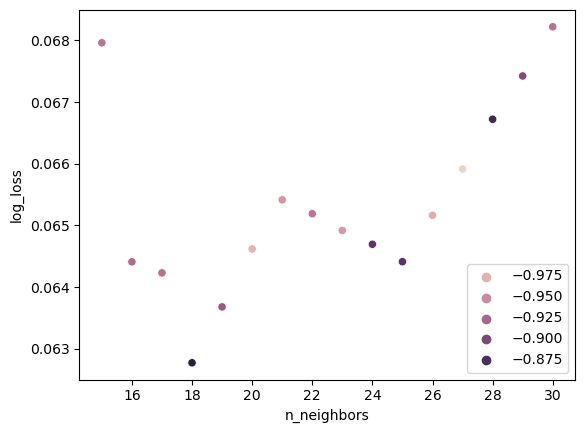

In [47]:
sns.scatterplot(x=n_neighbors, y=[-np.mean(cv['test_score']) for cv in cvs], hue=[-np.mean(cv['score_time']) for cv in cvs]);
plt.xlabel('n_neighbors')
plt.ylabel('log_loss')
plt.show()

In [48]:
# n=18 is the best model
final_knn_model = KNeighborsClassifier(n_neighbors=18).fit(X_train_scaled,y_train)

In [58]:
from sklearn.metrics import classification_report
y_pred = final_knn_model.predict(X_test_scaled)
final_knn_model_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print(classification_report(y_test, y_pred))
final_knn_model_report

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8939
           1       0.91      0.73      0.81       687

    accuracy                           0.98      9626
   macro avg       0.94      0.86      0.90      9626
weighted avg       0.97      0.98      0.97      9626



,precision,recall,f1-score,support
0,0.979608,0.994183,0.986841,8939.000000
1,0.906137,0.730713,0.809025,687.000000
accuracy,0.975379,0.975379,0.975379,0.975379
macro avg,0.942872,0.862448,0.897933,9626.000000
weighted avg,0.974364,0.975379,0.974151,9626.000000


### FINAL VS BASELINE ROC_AUC

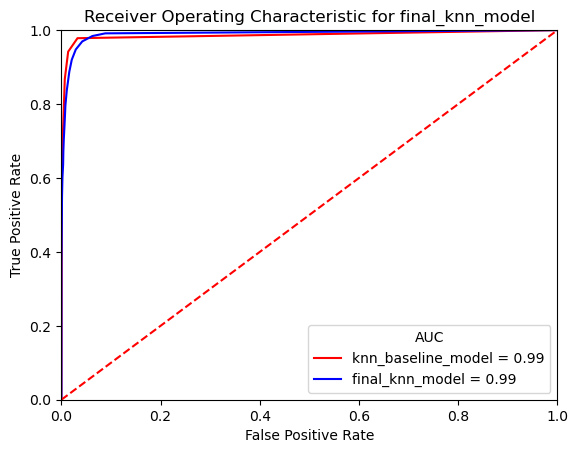

In [81]:
from sklearn.metrics import roc_curve, auc
compare_models = [knn_baseline_model, final_knn_model]
labels = ['knn_baseline_model', 'final_knn_model']
colors = ['red','blue']

fig, ax = plt.subplots()

# calculate the fpr and tpr for all thresholds of the classification
for i, model in enumerate(compare_models):
    fpr, tpr, threshold = roc_curve(y_test,[p[1] for p in model.predict_proba(X_test_scaled)])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label = f'{labels[i]} = %0.2f' % roc_auc, c=colors[i])
plt.title(f'Receiver Operating Characteristic for {labels[i]}')
plt.legend(loc = 'lower right', title='AUC')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [90]:
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)
baseline_cv = cross_validate(dt_baseline, X_train, y_train, scoring="neg_log_loss")
dtree_baseline_log_loss = -baseline_cv['test_score'].mean()
dtree_baseline_log_loss

0.7352281158853683

Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [91]:
# Replace None with appropriate text
"""
much worse thatn the .063 we were getting from knn, or the .13 from logReg, likely overfitting
"""

'\nmuch worse thatn the .063 we were getting from knn, or the .13 from logReg, likely overfitting\n'

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

In [97]:
dt_baseline.get_n_leaves()

446

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('dtree',DecisionTreeClassifier(random_state=42))])
pipe_grid = {'dtree__max_depth':[i for i in range(1,9)], 
             'dtree__class_weight':[None,'balanced'],
             'dtree__min_samples_leaf':[1,2,3,4,5,10,15,20,25,50,75,100,125,150,200,500,1000]}
# scoring=['neg_log_loss',
#          'accuracy', 
#          'balanced_accuracy',
#          'precision','recall',
#          'roc_auc',
#          'f1',
#          'f1_micro',
#          'f1_macro',
#          'f1_weighted']
gs_pipe = GridSearchCV(pipe,pipe_grid,scoring='neg_log_loss')
gs_pipe.fit(X_train,y_train)

final_dt_model = gs_pipe.best_estimator_
display(final_dt_model)
print(gs_pipe.best_score_)

Pipeline(steps=[('dtree',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=125,
                                        random_state=42))])

-0.0998087097709159


In [118]:
from sklearn.metrics import log_loss
y_pred = final_dt_model.predict(X_test)
final_dt_score = log_loss(y_test, y_pred)
final_dt_score

1.3442417999888905

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [124]:
from sklearn.metrics import log_loss
y_pred = final_dt_model.predict(X_test)
final_dt_score = log_loss(y_test, y_pred)

y_pred = final_knn_model.predict(X_test_scaled)
final_knn_score = log_loss(y_test,y_pred)
final_dt_score,final_knn_score

(1.3442417999888905, 0.8874242523603538)

In [126]:
# Replace None with appropriate code
final_model = final_knn_model

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=18)

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [130]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))
print("roc_auc:   ", roc_auc_score(y_test, preds))

log loss:  0.07643161716339113
accuracy:  0.9753791813837523
precision: 0.9061371841155235
recall:    0.7307132459970888
roc_auc:    0.8624480202465586


In [129]:
y_test.value_counts(normalize=True)

0    0.928631
1    0.071369
Name: Cover_Type, dtype: float64

Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [ ]:
# Replace None with appropriate text
"""
test set has 92% 0-labelled data, so the accuracy of .975 is very good, also very reasonable scores for the other metrics.
"""

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.